In [158]:
# This file implements the PhaseLift algorithm for phase retrieval

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Load or generate image

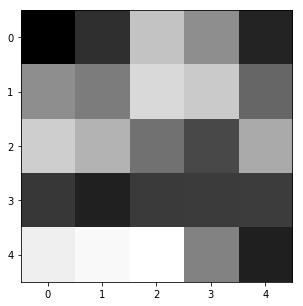

In [2]:
orig_img = Image.open("logo.jpg")
#image = np.array(orig_img.convert('L', (0.2989, 0.5870, 0.1140, 0))) # convert to gray
image = np.random.randn(5, 5)

%matplotlib inline
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
ax.imshow(image, cmap = plt.get_cmap('gray'))

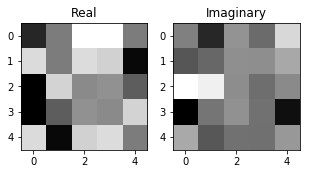

In [3]:
# Convert image to frequency domain
im_spectrum = np.fft.fft2(image)

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(5, 10))
ax[0].imshow(im_spectrum.real, cmap = plt.get_cmap('gray'))
ax[0].set_title('Real')
ax[1].imshow(im_spectrum.imag, cmap = plt.get_cmap('gray'))
ax[1].set_title('Imaginary')

x = im_spectrum.flatten()  # Convert the signal/image into a vector

## Create sampling vectors

In [4]:
# Define measurement operator
def measure(invecs):
    measurements = np.abs(np.dot(invecs, x))**2
    return measurements    

In [5]:
from functools import wraps

def normalizeable(genfunc, default=True):
    """Adds a keyword function to genfunc which allows normalization of the
    result (abs-sum over last axis yields 1)
    """

    @wraps(genfunc)
    def inner(*args, **kwargs):
        try:
            normalized = kwargs.pop('normalized')
        except KeyError:
            normalized = default

        result = genfunc(*args, **kwargs)
        return result / np.linalg.norm(result, axis=-1, keepdims=True) if normalized \
            else result

    return inner


@normalizeable
def invecs_gaussian(dim, length, rgen=np.random):
    """Generates complex Gaussian random vectors with iid, N(0,1) + iN(0,1)
    components

    :param dim: Dimension of the vectors (# of components)
    :param length: Number of vectors
    :param rgen: Instance of `numpy.random.RandomState` (default: `np.random`)
    :returns: (length,dim) numpy array

    """
    return rgen.randn(length, dim) + 1.j * rgen.randn(length, dim)


@normalizeable
def invecs_recr(dim, nr_mm, p_erasure=1 / 2, rgen=np.random):
    """Generates random preparation vectors with iid components distributed
    accorgening to a random-erased complex Rademacher (RECR) distribution,
    that is x_i = a_i * phi_i, where

        a_i ~ Bernoulli(p_erasure), phi_i ~ Uniform({1, -1, i, -i})

    :param dim: Dimension of the vectors (# of components)
    :param length: Number of vectors
    :param p_erasure: Erasure probability
    :returns: (length,dim) numpy array

    """
    pvecs = []
    while len(pvecs) < nr_mm:
        phase = rgen.choice([1, -1, 1j, -1j], size=dim)
        amplitude = rgen.choice([0, 1], size=dim, p=[p_erasure, 1 - p_erasure])
        # this penalizes the choice of zero for small values of dim
        if np.sum(amplitude) > 0:
            pvecs.append(phase * amplitude)
    return np.reshape(pvecs, (nr_mm, dim))


## Define optimization routines

In [22]:
import cvxpy as cvx

def _semidef_complex_as_real(dim):
    """Returns a cvxpy Semidefinite matrix and constraints for representing
    a complex hermitian non-neg. matrix represented as

                            Z = X + iY   <==> Z' = [X -Y; Y X]    (*)

    :param dim: Dimension of the complex matrix
    :returns: cvxpy.Semidef(2 * dim), List of constaints ensuring the structure
        in (*)

    """
    z = cvx.Variable([2 * dim, 2 * dim])
    z.nonneg = True
    constraints = [
	z[:dim, :dim] == z[dim:, dim:],
        z[:dim, dim:] == -z[dim:, :dim]
    ]
    return z, constraints

def lr_recover_l1(invecs, intensities, nonneg=True, **kwargs):
    """Computes the low-rank matrix reconstruction using l1-minimisation

    .. math::

            \min_Z \sum_i \vert \langle a_i| Z | a_i \rangle - y_i \vert \\
            \mathrm{s.t.}  Z \ge 0

    where :math:`a_i` are the input vectors and :math:`y_i` are the measured
    intensities.

    For the arguments not listed see :func:`recover`

    :param bool nonneg: Enfornce the constraint Z >= 0 (default True)
    :param kwargs: Additional arguemnts passed to `cvx.Problem.solve`
    :returns: array of shape (dim, dim); Low-rank matrix approximation for
        given measurements

    """
    dim = invecs.shape[1]

    # we have to manually convert convex programm to real form since cvxpy
    # does not support complex programms
    z, mat_cons = _semidef_complex_as_real(dim) if nonneg else \
        _hermitian_as_real(dim)
    invecs_real = np.concatenate((invecs.real, invecs.imag), axis=1)

    obj = cvx.Minimize(sum(cvx.abs(cvx.quad_form(a, z) - y)
                           for a, y in zip(invecs_real, intensities)))

    prob = cvx.Problem(obj, mat_cons)
    prob.solve(**kwargs)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise RuntimeError("Optimization did not converge: " + prob.status)

    return z.value[:dim, :dim] + 1.j * z.value[dim:, :dim]


def lr_recover_l2(invecs, intensities, nonneg=True, **kwargs):
    """Same as :func:`lr_recover_l1`, but using l2-minimisation

    .. math::

            \min_Z \sum_i \vert \langle a_i| Z | a_i \rangle - y_i \vert^2 \\
            \mathrm{s.t.}  Z \ge 0

    """
    dim = invecs.shape[1]
    z, mat_cons = _semidef_complex_as_real(dim) if nonneg else \
        _hermitian_as_real(dim)
    invecs_real = np.concatenate((invecs.real, invecs.imag), axis=1)

    obj = cvx.Minimize(sum((cvx.quad_form(a, z) - y)**2
                           for a, y in zip(invecs_real, intensities)))

    prob = cvx.Problem(obj, mat_cons)
    prob.solve(**kwargs)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise RuntimeError("Optimization did not converge: " + prob.status)

    return z.value[:dim, :dim] + 1.j * z.value[dim:, :dim]


def lr_recover_nuclear(invecs, intensities, noise_bound=None, nonneg=True,
                       **kwargs):
    """Same as :func:`lr_recover_l1`, but using nuclear norm-minimisation

    .. math::

            \min_Z \Vert Z \Vert_1
            \mathrm{s.t.} \sum_i \vert \langle a_i| Z | a_i \rangle - y_i \vert^2 \le \eta^2
                           Z \ge 0

    Here, :math:`\eta` denotes an additional a-priori noise bound. If
    `noise_bound` is set to `None`, we assume noiseless measurements and
    solve the following equality constrained programm instead:

    .. math::

            \min_Z \Vert Z \Vert_1
            \mathrm{s.t.} \langle a_i| Z | a_i \rangle = y_i
                           Z \ge 0

    Note that :func:`lr_recover_l1` and :func:`lr_recover_l2` do not require
    an a priori noise bound and usually perform better.

    :param float noise_bound: Bound for the column-wise noise :math:`\epsilon`:

    .. math::

            \Vert \epsilon \Vert_2 \le \eta
    """
    dim = invecs.shape[1]
    z, mat_cons = _semidef_complex_as_real(dim) if nonneg else \
        _hermitian_as_real(dim)
    invecs_real = np.concatenate((invecs.real, invecs.imag), axis=1)

    obj = cvx.Minimize(cvx.norm(z, 'nuc'))
    if noise_bound is None:
        cons = [cvx.quad_form(a, z) == y for a, y in
                zip(invecs_real, intensities)]
    else:
        cons = [sum(cvx.square(cvx.quad_form(a, z) - y)
                    for a, y in zip(invecs_real, intensities)) <= noise_bound**2]

    prob = cvx.Problem(obj, cons + mat_cons)
    prob.solve(**kwargs)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise RuntimeError("Optimization did not converge: " + prob.status)

    return z.value[:dim, :dim] + 1.j * z.value[dim:, :dim]


def rank1_approx(mat, reterr=False):
    """Returns the best rank 1 approximation to `mat`, i.e. the singular
    vector corresponding to the largest singular value.

    :param mat: Hermitian matrix as `numpy.ndarray` with shape `(dim, dim)`.
    :param reterr: Return the sum of the truncated singular values
    :returns: Largest singular vector. If reterr==True, we also return the
        error given by the sum of the discarded singular values

    """
    vals, vecs = np.linalg.eigh(mat)
    if reterr:
        return np.sqrt(vals[-1]) * vecs[:, -1], np.sum(vals[:-1]) / vals[-1]
    else:
        return np.sqrt(vals[-1]) * vecs[:, -1]

## Finally, run recovery

In [23]:
# lower and upper bounds of number of measurements (as a function of size)
dim = len(x)
NSAMPLES = 20 * dim 

INVECS_GENERATOR = invecs_gaussian
OPTIM_FUNC = lr_recover_nuclear

In [24]:
invecs = INVECS_GENERATOR(dim, NSAMPLES)
intensities = measure(invecs)

# Find X. This takes time
result = OPTIM_FUNC(invecs, intensities)

In [25]:
# Extract X and get error
x_rec, err = rank1_approx(result, reterr=True)
print(f"rank-1 error: {err}")

image_rec = np.fft.ifft2(x_rec.conj().reshape(5, 5))

rank-1 error: -0.0004668097342599583


Text(0.5,1,'Original')

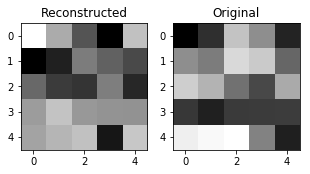

In [26]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(5, 10))
ax[0].imshow(np.abs(image_rec), cmap = plt.get_cmap('gray'))
ax[1].imshow(image, cmap = plt.get_cmap('gray'))
ax[0].set_title('Reconstructed')
ax[1].set_title('Original')

In [ ]:
## Test error decay width the number of examples